Запустить seq2seq, seq2seq с внимаием для перевода русских слов + описать наблюдения по качеству
Данные в папке data
Дополнительное задание
переделать генерацию текста по символам в генерацию по словам

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
import numpy as np

In [2]:
batch_size = 1024
epochs = 50
latent_dim = 256
num_samples = 30000
data_path = 'data/rus-eng/rus.txt'

In [3]:
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read()[:1000]
    print(lines)

Go.	Марш!	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1159202 (shanghainese)
Go.	Иди.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #5898247 (marafon)
Go.	Идите.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #5898250 (marafon)
Hi.	Здравствуйте.	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #402127 (odexed)
Hi.	Привет!	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #466968 (katjka)
Hi.	Хай.	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #467233 (timsa)
Hi.	Здрасте.	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #3803577 (marafon)
Hi.	Здоро́во!	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #3854188 (marafon)
Run!	Беги!	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #1569978 (Biga)
Run!	Бегите!	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #2770234 (marafon)
Run.	Беги!	CC-BY 2.0 (France) Attribution: tatoeba.org #4008918 (JSakuragi) & #1569978 (Bi

### Предобработка текста в последовательности

In [4]:
# Собираем из текстов токены и делаем one-hot вектора на каждый токен

input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split('\t')
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [5]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

In [6]:
print(input_characters)
print(target_characters)

[' ', '!', '"', '$', '%', '&', "'", ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'é']
['\t', '\n', ' ', '!', '"', '%', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '?', 'C', 'D', 'F', 'N', 'P', 'V', 'a', 'd', 'e', 'f', 'i', 'o', 'r', 'x', '\xa0', '«', '»', '́', 'А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж', 'З', 'И', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х', 'Ц', 'Ч', 'Ш', 'Э', 'Я', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', 'ё', '\u200b', '–', '—']


In [7]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

In [8]:
input_token_index['!']

1

In [9]:
# Задаем размеры последовательности

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.

### Обучение базового seq2seq

Генерация текста. В данной модели в LSTM-ячейку подается посимвольная последовательность

In [50]:
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)

# Подача выхода энкодера в декодер
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Подача выхода декодера в модель
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())



Epoch 1/50
24/24 [==============================] - 60s 2s/step - loss: 2.1136 - accuracy: 0.7201 - val_loss: 1.4736 - val_accuracy: 0.7274
Epoch 2/50
24/24 [==============================] - 59s 2s/step - loss: 1.2409 - accuracy: 0.7524 - val_loss: 1.3089 - val_accuracy: 0.7269
Epoch 3/50
24/24 [==============================] - 59s 2s/step - loss: 1.1256 - accuracy: 0.7538 - val_loss: 1.2203 - val_accuracy: 0.7150
Epoch 4/50
24/24 [==============================] - 59s 2s/step - loss: 1.0497 - accuracy: 0.7499 - val_loss: 1.1481 - val_accuracy: 0.7147
Epoch 5/50
24/24 [==============================] - 59s 2s/step - loss: 0.9770 - accuracy: 0.7523 - val_loss: 1.0673 - val_accuracy: 0.7282
Epoch 6/50
24/24 [==============================] - 59s 2s/step - loss: 0.9236 - accuracy: 0.7586 - val_loss: 1.0215 - val_accuracy: 0.7283
Epoch 7/50
24/24 [==============================] - 59s 2s/step - loss: 0.8857 - accuracy: 0.7594 - val_loss: 0.9876 - val_accuracy: 0.7321
Epoch 8/50
24/24 [==

In [51]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_token_index['\t']] = 1.

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        states_value = [h, c]

    return decoded_sentence

In [52]:
for seq_index in range(0, 500, 10):
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: <start> Go <end>
Decoded sentence: Подерите сень.

-
Input sentence: <start> Run <end>
Decoded sentence: Подите ене.

-
Input sentence: <start> Fire <end>
Decoded sentence: Пойди!

-
Input sentence: <start> Stop <end>
Decoded sentence: Поздить!

-
Input sentence: <start> Go on <end>
Decoded sentence: Подидите себя.

-
Input sentence: <start> I see <end>
Decoded sentence: Я порадил.

-
Input sentence: <start> Oh no <end>
Decoded sentence: Вот меня!

-
Input sentence: <start> Smile <end>
Decoded sentence: Позвать есь.

-
Input sentence: <start> Freeze <end>
Decoded sentence: Поторите!

-
Input sentence: <start> Go now <end>
Decoded sentence: Подидите себя.

-
Input sentence: <start> He ran <end>
Decoded sentence: Он поравить.

-
Input sentence: <start> I know <end>
Decoded sentence: Я проволина.

-
Input sentence: <start> I paid <end>
Decoded sentence: Я провила.

-
Input sentence: <start> I m up <end>
Decoded sentence: Я провидел.

-
Input sentence: <start> No way <end

## Поднимемся на уровень слов, чтобы можно было что-то более адекватное посчитать за адекватное время

## Добавление Attention уровня

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
import numpy as np

import re
import tensorflow as tf
data_path = 'data/rus-eng/rus.txt'
num_samples = 10000

#tf.enable_eager_execution()

input_texts = []
target_texts = []

def preprocess_sentence(w):
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Zа-яА-Я]+", " ", w)
    w = w.strip()
    w = '<start> ' + w + ' <end>'
    return w



with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
    


for line in lines[: min(num_samples, len(lines) - 1)]:
    print(line)
    input_text, target_text, _ = line.split('\t')
    target_text = '\t' + target_text + '\n'
    input_texts.append(preprocess_sentence(input_text))
    target_texts.append(preprocess_sentence(target_text))
    


Go.	Марш!	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1159202 (shanghainese)
Go.	Иди.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #5898247 (marafon)
Go.	Идите.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #5898250 (marafon)
Hi.	Здравствуйте.	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #402127 (odexed)
Hi.	Привет!	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #466968 (katjka)
Hi.	Хай.	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #467233 (timsa)
Hi.	Здрасте.	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #3803577 (marafon)
Hi.	Здоро́во!	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #3854188 (marafon)
Run!	Беги!	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #1569978 (Biga)
Run!	Бегите!	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #2770234 (marafon)
Run.	Беги!	CC-BY 2.0 (France) Attribution: tatoeba.org #4008918 (JSakuragi) & #1569978 (Bi

Stay here.	Побудь здесь.	CC-BY 2.0 (France) Attribution: tatoeba.org #2111512 (CK) & #5143708 (marafon)
Stay here.	Побудьте здесь.	CC-BY 2.0 (France) Attribution: tatoeba.org #2111512 (CK) & #5143710 (marafon)
Stay here.	Побудь тут.	CC-BY 2.0 (France) Attribution: tatoeba.org #2111512 (CK) & #5143712 (marafon)
Stay here.	Побудьте тут.	CC-BY 2.0 (France) Attribution: tatoeba.org #2111512 (CK) & #5143713 (marafon)
Stay home.	Оставайтесь дома.	CC-BY 2.0 (France) Attribution: tatoeba.org #8624434 (Adelpa) & #1942642 (Balamax)
Stay home.	Оставайся дома.	CC-BY 2.0 (France) Attribution: tatoeba.org #8624434 (Adelpa) & #3299308 (marafon)
Step back.	Отойди.	CC-BY 2.0 (France) Attribution: tatoeba.org #1553393 (CK) & #3257517 (marafon)
Step back.	Сделай шаг назад.	CC-BY 2.0 (France) Attribution: tatoeba.org #1553393 (CK) & #4450389 (odexed)
Stop here.	Остановись здесь.	CC-BY 2.0 (France) Attribution: tatoeba.org #2111500 (CK) & #2501622 (paul_lingvo)
Stop here.	Остановись тут.	CC-BY 2.0 (France)

Tom's safe.	Том в безопасности.	CC-BY 2.0 (France) Attribution: tatoeba.org #2107587 (CK) & #5318123 (odexed)
Tom's shot.	Том застрелен.	CC-BY 2.0 (France) Attribution: tatoeba.org #2107592 (CK) & #2115029 (shanghainese)
Tom's sick.	Том болен.	CC-BY 2.0 (France) Attribution: tatoeba.org #2107594 (CK) & #2297040 (Balamax)
Tom's sick.	Том болеет.	CC-BY 2.0 (France) Attribution: tatoeba.org #2107594 (CK) & #2723341 (marafon)
Tom's ugly.	Том некрасив.	CC-BY 2.0 (France) Attribution: tatoeba.org #2107631 (CK) & #4953673 (odexed)
Tom's ugly.	Том некрасивый.	CC-BY 2.0 (France) Attribution: tatoeba.org #2107631 (CK) & #5892940 (marafon)
Tom's weak.	Том слаб.	CC-BY 2.0 (France) Attribution: tatoeba.org #2107651 (CK) & #2501723 (paul_lingvo)
Tom's weak.	Том слабый.	CC-BY 2.0 (France) Attribution: tatoeba.org #2107651 (CK) & #2501724 (paul_lingvo)
Tom's well.	Том в порядке.	CC-BY 2.0 (France) Attribution: tatoeba.org #2107653 (CK) & #3232726 (marafon)
Try harder.	Больше старайся.	CC-BY 2.0 (Franc

She woke up.	Она проснулась.	CC-BY 2.0 (France) Attribution: tatoeba.org #528455 (fanty) & #803993 (Arkadeko)
She's a dog.	Это сука.	CC-BY 2.0 (France) Attribution: tatoeba.org #1764721 (CK) & #2563519 (odexed)
She's a dog.	Она карга.	CC-BY 2.0 (France) Attribution: tatoeba.org #1764721 (CK) & #3508368 (Ooneykcall)
She's a dog.	Она уродина.	CC-BY 2.0 (France) Attribution: tatoeba.org #1764721 (CK) & #5041787 (tikan0)
She's a dog.	Она собака.	CC-BY 2.0 (France) Attribution: tatoeba.org #1764721 (CK) & #5041789 (tikan0)
She's crazy.	Она сумасшедшая.	CC-BY 2.0 (France) Attribution: tatoeba.org #1437171 (CM) & #2560456 (marafon)
She's timid.	Она застенчивая.	CC-BY 2.0 (France) Attribution: tatoeba.org #2935005 (CM) & #5885547 (marafon)
Should I go?	Мне уйти?	CC-BY 2.0 (France) Attribution: tatoeba.org #1454593 (CK) & #2124493 (marafon)
Should I go?	Мне пойти?	CC-BY 2.0 (France) Attribution: tatoeba.org #1454593 (CK) & #4947958 (marafon)
Show me how.	Покажи мне как.	CC-BY 2.0 (France) Attri

I set a trap.	Я устроил ловушку.	CC-BY 2.0 (France) Attribution: tatoeba.org #5829185 (CK) & #6985151 (odexed)
I should eat.	Мне надо поесть.	CC-BY 2.0 (France) Attribution: tatoeba.org #8847819 (CK) & #4597122 (marafon)
I still swim.	Я ещё плаваю.	CC-BY 2.0 (France) Attribution: tatoeba.org #5576494 (CK) & #5585996 (marafon)
I suppose so.	Я так думаю.	CC-BY 2.0 (France) Attribution: tatoeba.org #51064 (CK) & #3060647 (sharptoothed)
I suppose so.	Полагаю, что так.	CC-BY 2.0 (France) Attribution: tatoeba.org #51064 (CK) & #4682128 (marafon)
I swim a lot.	Я много плаваю.	CC-BY 2.0 (France) Attribution: tatoeba.org #5576753 (CK) & #5579532 (odexed)
I sympathize.	Я сочувствую.	CC-BY 2.0 (France) Attribution: tatoeba.org #2111795 (CK) & #2356071 (corvard)
I talk a lot.	Я много говорю.	CC-BY 2.0 (France) Attribution: tatoeba.org #2631830 (Joseph) & #4588300 (marafon)
I teach here.	Я преподаю здесь.	CC-BY 2.0 (France) Attribution: tatoeba.org #2247419 (CK) & #2606516 (Olya)
I teach yoga.	Я пр

They'll fail.	У них ничего не выйдет.	CC-BY 2.0 (France) Attribution: tatoeba.org #4397553 (CK) & #2792459 (marafon)
They'll fail.	У них ничего не получится.	CC-BY 2.0 (France) Attribution: tatoeba.org #4397553 (CK) & #2792461 (marafon)
They'll grow.	Они вырастут.	CC-BY 2.0 (France) Attribution: tatoeba.org #4397552 (CK) & #4830252 (odexed)
They'll know.	Они узнают.	CC-BY 2.0 (France) Attribution: tatoeba.org #2123543 (CK) & #2270219 (marafon)
They'll wait.	Они будут ждать.	CC-BY 2.0 (France) Attribution: tatoeba.org #2111341 (CK) & #4921008 (odexed)
They'll wait.	Они подождут.	CC-BY 2.0 (France) Attribution: tatoeba.org #2111341 (CK) & #4921009 (odexed)
They're back.	Они вернулись.	CC-BY 2.0 (France) Attribution: tatoeba.org #2111331 (CK) & #4868200 (odexed)
They're blue.	Они голубые.	CC-BY 2.0 (France) Attribution: tatoeba.org #2549750 (CK) & #5202169 (odexed)
They're boys.	Они мальчики.	CC-BY 2.0 (France) Attribution: tatoeba.org #2111326 (CK) & #4406620 (Balamax)
They're boys.	Они 

Finish eating.	Доедай.	CC-BY 2.0 (France) Attribution: tatoeba.org #8586627 (CK) & #2021484 (shanghainese)
Finish eating.	Доедайте.	CC-BY 2.0 (France) Attribution: tatoeba.org #8586627 (CK) & #8586633 (marafon)
Fix the clock.	Почините часы.	CC-BY 2.0 (France) Attribution: tatoeba.org #579141 (FeuDRenais) & #5281819 (odexed)
Fix the watch.	Почините часы.	CC-BY 2.0 (France) Attribution: tatoeba.org #579140 (FeuDRenais) & #5281819 (odexed)
Flowers bloom.	Цветы цветут.	CC-BY 2.0 (France) Attribution: tatoeba.org #23749 (CK) & #576519 (Tonari)
Fry me an egg.	Пожарь мне яйцо.	CC-BY 2.0 (France) Attribution: tatoeba.org #2766914 (CK) & #2596154 (sharptoothed)
Get a haircut.	Подстригись.	CC-BY 2.0 (France) Attribution: tatoeba.org #949996 (CK) & #3594497 (sharptoothed)
Get a move on!	Поторапливайся!	CC-BY 2.0 (France) Attribution: tatoeba.org #328232 (fcbond) & #351199 (shanghainese)
Get a move on!	Живей!	CC-BY 2.0 (France) Attribution: tatoeba.org #328232 (fcbond) & #2034650 (everlasting)
Get

In [17]:
input_texts[:2], target_texts[:2]

(['<start> Go <end>', '<start> Go <end>'],
 ['<start> Марш <end>', '<start> Иди <end>'])

In [18]:
lines[:5]

['Go.\tМарш!\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1159202 (shanghainese)',
 'Go.\tИди.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #5898247 (marafon)',
 'Go.\tИдите.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #5898250 (marafon)',
 'Hi.\tЗдравствуйте.\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #402127 (odexed)',
 'Hi.\tПривет!\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #466968 (katjka)']

In [19]:
inp, out, _ = lines[0].split("\t")
print("input:", inp)
print("groundtruth:", out)
print("-", _)

input: Go.
groundtruth: Марш!
- CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1159202 (shanghainese)


In [20]:
preprocess_sentence(out)

'<start> Марш <end>'

In [22]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')
    return tensor, lang_tokenizer

In [23]:
input_tensor, inp_lang_tokenizer = tokenize(input_texts)
target_tensor, targ_lang_tokenizer = tokenize(target_texts)

In [24]:
from sklearn.model_selection import train_test_split

input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

In [25]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024

vocab_inp_size = len(inp_lang_tokenizer.word_index)+1
vocab_tar_size = len(targ_lang_tokenizer.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [26]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True)

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.lstm(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

    
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights
    
    
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state = self.lstm(x)
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)
        return x, state, attention_weights

In [27]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [28]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([targ_lang_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

        for t in range(1, targ.shape[1]):
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions)
            dec_input = tf.expand_dims(targ[:, t], 1)
    
    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss

In [29]:
EPOCHS = 10
for epoch in range(EPOCHS):
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss
    
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))

Epoch 1 Loss 1.8038
Epoch 2 Loss 1.4312
Epoch 3 Loss 1.2449
Epoch 4 Loss 1.0652
Epoch 5 Loss 0.8982
Epoch 6 Loss 0.7336
Epoch 7 Loss 0.5917
Epoch 8 Loss 0.4771
Epoch 9 Loss 0.3910
Epoch 10 Loss 0.3318


In [30]:
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

from matplotlib import pyplot as plt
from matplotlib import ticker

def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    sentence = preprocess_sentence(sentence)
    inputs = [inp_lang_tokenizer.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
    inputs = tf.convert_to_tensor(inputs)
    result = ''
    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang_tokenizer.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang_tokenizer.index_word[predicted_id] + ' '

        if targ_lang_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        dec_input = tf.expand_dims([predicted_id], 0)
    return result, sentence, attention_plot

def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    fontdict = {'fontsize': 14}
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()
    
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Populating the interactive namespace from numpy and matplotlib
Input: <start> good morning <end>
Predicted translation: доброе утро <end> 


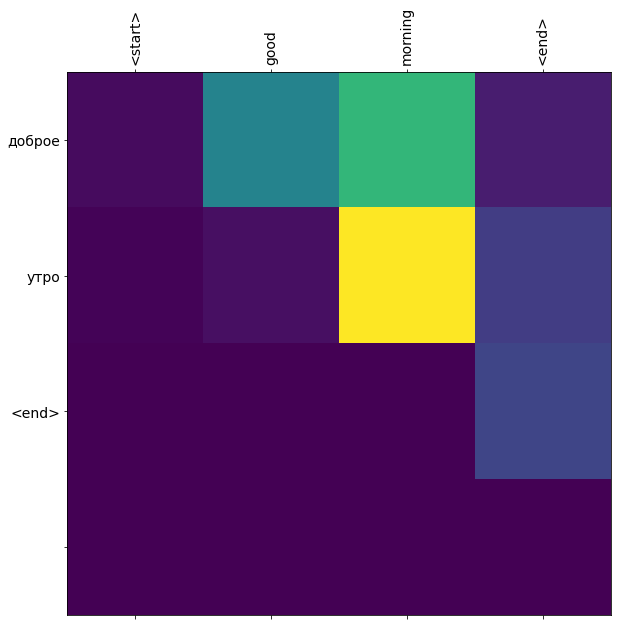

In [31]:
%pylab inline

translate(u'good morning')

Populating the interactive namespace from numpy and matplotlib
Input: <start> good for you <end>
Predicted translation: хорошо вы <end> 


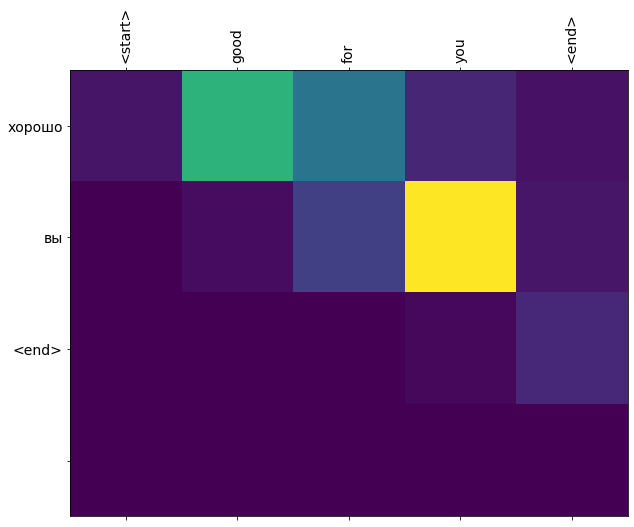

In [33]:
%pylab inline

translate(u'good for you')

# Transformer

Идея в том, что каждое слово параллельно проходит через слои, изображенные на картинке.
Некоторые из них — это стандартные fully-connected layers, некоторые — shortcut connections как в ResNet (там, где на картинке Add).


Multi-head attention - это специальный новый слой, который дает возможность каждому входному вектору взаимодействовать с другими словами через attention mechanism, вместо передачи hidden state как в RNN или соседних слов как в CNN.



Работа энкодера:


Делаются эмбеддинги для всех слов предложения (вектора одинаковой размерности). Для примера пусть это будет предложение I am stupid. В эмбеддинг добавляется еще позиция слова в предложении.


Берется вектор первого слова и вектор второго слова (I, am), подаются на однослойную сеть с одним выходом, которая выдает степень их похожести (скалярная величина). Эта скалярная величина умножается на вектор второго слова, получая его некоторую "ослабленную" на величину похожести копию.


Вместо второго слова подается третье слово и делается тоже самое что в п.2. с той же самой сетью с теми же весами (для векторов I, stupid).


Делая тоже самое для всех оставшихся слов предложения получаются их "ослабленные" (взвешенные) копии, которые выражают степень их похожести на первое слово. Далее эти все взвешенные вектора складываются друг с другом, получая один результирующий вектор размерности одного эмбединга:
output=am * weight(I, am) + stupid * weight(I, stupid)


Это механизм "обычного" attention.
Так как оценка похожести слов всего одним способом (по одному критерию) считается недостаточной, тоже самое (п.2-4) повторяется несколько раз с другими весами. Типа одна один attention может определять похожесть слов по смысловой нагрузке, другой по грамматической, остальные еще как-то и т.п.


На выходе п.5. получается несколько векторов, каждый из которых является взвешенной суммой всех остальных слов предложения относительно их похожести на первое слово (I). Конкантенируем этот вректор в один.


Дальше ставится еще один слой линейного преобразования, уменьшающий размерность результата п.6. до размерности вектора одного эмбединга. Получается некое представление первого слова предложения, составленное из взвешенных векторов всех остальных слов предложения.


Такой же процесс производится для всех других слов в предложении.


Так как размерность выхода та же, то можно проделать все тоже самое еще раз (п.2-8), но вместо оригинальных эмбеддингов слов взять то, что получается после прохода через этот Multi-head attention, а нейросети аттеншенов внутри взять с другими весами (веса между слоями не общие). И таких слоев можно сделать много (у гугла 6). Однако между первым и вторым слоем добавляется еще полносвязный слой и residual соединения, чтобы добавить сети выразительности.

In [34]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)
    return output, attention_weights

In [35]:
class MultiHeadAttention(tf.keras.layers.Layer):
    
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        
        """Разделение последней размерности на (num_heads, depth).
        Транспонирование реультата к размерности (batch_size, num_heads, seq_len, depth)
        """
        
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights
    
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [36]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):

        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2
    
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    
    def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2
    
    
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.d_model)


        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):

        seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)

In [37]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

In [38]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                               input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                               target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights

In [39]:
# 
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = len(inp_lang_tokenizer.index_word) + 2
target_vocab_size = len(targ_lang_tokenizer.index_word) + 2
dropout_rate = 0.1

In [40]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [41]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
  
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [42]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

In [43]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [44]:
def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
  
    dec_padding_mask = create_padding_mask(inp)
  
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
    return enc_padding_mask, combined_mask, dec_padding_mask

In [45]:

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
    tf.TensorSpec(shape=(None, None), dtype=tf.int32),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
  
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
    train_loss(loss)
    train_accuracy(tar_real, predictions)

In [46]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

for epoch in range(100):
    train_loss.reset_states()
    train_accuracy.reset_states()
  
    for (batch, (inp, tar)) in enumerate(dataset.take(steps_per_epoch)):
        train_step(inp, tar)
        if batch % 50 == 0:
            print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
              epoch + 1, batch, train_loss.result(), train_accuracy.result()))
    
    print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

Epoch 1 Batch 0 Loss 8.5089 Accuracy 0.0000
Epoch 1 Batch 50 Loss 8.3098 Accuracy 0.0281
Epoch 1 Batch 100 Loss 8.0223 Accuracy 0.0692
Epoch 1 Loss 7.9160 Accuracy 0.0772
Epoch 2 Batch 0 Loss 7.4089 Accuracy 0.1111
Epoch 2 Batch 50 Loss 7.2378 Accuracy 0.1111
Epoch 2 Batch 100 Loss 7.0620 Accuracy 0.1118
Epoch 2 Loss 6.9719 Accuracy 0.1158
Epoch 3 Batch 0 Loss 6.5037 Accuracy 0.1337
Epoch 3 Batch 50 Loss 6.2294 Accuracy 0.1393
Epoch 3 Batch 100 Loss 6.0097 Accuracy 0.1401
Epoch 3 Loss 5.9049 Accuracy 0.1406
Epoch 4 Batch 0 Loss 5.2680 Accuracy 0.1441
Epoch 4 Batch 50 Loss 5.1796 Accuracy 0.1447
Epoch 4 Batch 100 Loss 5.0593 Accuracy 0.1466
Epoch 4 Loss 4.9985 Accuracy 0.1479
Epoch 5 Batch 0 Loss 4.7313 Accuracy 0.1424
Epoch 5 Batch 50 Loss 4.5536 Accuracy 0.1599
Epoch 5 Batch 100 Loss 4.4791 Accuracy 0.1645
Epoch 5 Loss 4.4373 Accuracy 0.1659
Epoch 6 Batch 0 Loss 4.1596 Accuracy 0.1562
Epoch 6 Batch 50 Loss 4.1266 Accuracy 0.1744
Epoch 6 Batch 100 Loss 4.0697 Accuracy 0.1762
Epoch 6 Lo

Epoch 48 Batch 50 Loss 0.5152 Accuracy 0.3238
Epoch 48 Batch 100 Loss 0.5674 Accuracy 0.3181
Epoch 48 Loss 0.5976 Accuracy 0.3151
Epoch 49 Batch 0 Loss 0.4537 Accuracy 0.3264
Epoch 49 Batch 50 Loss 0.5179 Accuracy 0.3221
Epoch 49 Batch 100 Loss 0.5659 Accuracy 0.3192
Epoch 49 Loss 0.5894 Accuracy 0.3158
Epoch 50 Batch 0 Loss 0.4425 Accuracy 0.3160
Epoch 50 Batch 50 Loss 0.5016 Accuracy 0.3252
Epoch 50 Batch 100 Loss 0.5630 Accuracy 0.3184
Epoch 50 Loss 0.5834 Accuracy 0.3156
Epoch 51 Batch 0 Loss 0.3822 Accuracy 0.3351
Epoch 51 Batch 50 Loss 0.5014 Accuracy 0.3240
Epoch 51 Batch 100 Loss 0.5564 Accuracy 0.3182
Epoch 51 Loss 0.5754 Accuracy 0.3170
Epoch 52 Batch 0 Loss 0.4220 Accuracy 0.3403
Epoch 52 Batch 50 Loss 0.4931 Accuracy 0.3241
Epoch 52 Batch 100 Loss 0.5486 Accuracy 0.3200
Epoch 52 Loss 0.5713 Accuracy 0.3171
Epoch 53 Batch 0 Loss 0.4034 Accuracy 0.3281
Epoch 53 Batch 50 Loss 0.4831 Accuracy 0.3276
Epoch 53 Batch 100 Loss 0.5396 Accuracy 0.3201
Epoch 53 Loss 0.5618 Accuracy 0.

Epoch 95 Batch 50 Loss 0.3753 Accuracy 0.3310
Epoch 95 Batch 100 Loss 0.4156 Accuracy 0.3267
Epoch 95 Loss 0.4334 Accuracy 0.3253
Epoch 96 Batch 0 Loss 0.3216 Accuracy 0.3351
Epoch 96 Batch 50 Loss 0.3773 Accuracy 0.3324
Epoch 96 Batch 100 Loss 0.4207 Accuracy 0.3271
Epoch 96 Loss 0.4388 Accuracy 0.3252
Epoch 97 Batch 0 Loss 0.3325 Accuracy 0.3194
Epoch 97 Batch 50 Loss 0.3804 Accuracy 0.3318
Epoch 97 Batch 100 Loss 0.4235 Accuracy 0.3262
Epoch 97 Loss 0.4357 Accuracy 0.3247
Epoch 98 Batch 0 Loss 0.4467 Accuracy 0.3316
Epoch 98 Batch 50 Loss 0.3609 Accuracy 0.3327
Epoch 98 Batch 100 Loss 0.4107 Accuracy 0.3261
Epoch 98 Loss 0.4313 Accuracy 0.3245
Epoch 99 Batch 0 Loss 0.3681 Accuracy 0.3299
Epoch 99 Batch 50 Loss 0.3746 Accuracy 0.3314
Epoch 99 Batch 100 Loss 0.4174 Accuracy 0.3271
Epoch 99 Loss 0.4346 Accuracy 0.3252
Epoch 100 Batch 0 Loss 0.3373 Accuracy 0.3264
Epoch 100 Batch 50 Loss 0.3799 Accuracy 0.3328
Epoch 100 Batch 100 Loss 0.4161 Accuracy 0.3267
Epoch 100 Loss 0.4316 Accurac

In [47]:
def evaluate(inp_sentence):
    start_token = [1]
    end_token = [2]
  
    sentence = preprocess_sentence(inp_sentence)
    inputs = [inp_lang_tokenizer.word_index[i] for i in sentence.split(' ')]
    
    encoder_input = tf.expand_dims(inputs, 0)
  
  # as the target is english, the first word to the transformer should be the
  # english start token.
    decoder_input = [1]
    output = tf.expand_dims(decoder_input, 0)
    
    for i in range(max_length_targ):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            encoder_input, output)
  
    # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    
    # select the last word from the seq_len dimension
        predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # return the result if the predicted_id is equal to the end token
        if predicted_id == targ_lang_tokenizer.word_index["<end>"]:
            return tf.squeeze(output, axis=0), attention_weights
    
    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights


def plot_attention_weights(attention, sentence, result, layer):
    fig = plt.figure(figsize=(16, 8))
  
    sentence = inp_lang_tokenizer.encode(sentence)
  
    attention = tf.squeeze(attention[layer], axis=0)
  
    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head+1)

        # plot the attention weights
        ax.matshow(attention[head][:-1, :], cmap='viridis')

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(sentence)+2))
        ax.set_yticks(range(len(result)))

        ax.set_ylim(len(result)-1.5, -0.5)

        ax.set_xticklabels(
            ['<start>']+[tokenizer_pt.decode([i]) for i in sentence]+['<end>'], 
            fontdict=fontdict, rotation=90)

        ax.set_yticklabels([tokenizer_en.decode([i]) for i in result 
                            if i < tokenizer_en.vocab_size], 
                           fontdict=fontdict)

        ax.set_xlabel('Head {}'.format(head+1))
  
    plt.tight_layout()
    plt.show()

def translate(sentence, plot=''):
    result, attention_weights = evaluate(sentence)
    predicted_sentence = ([targ_lang_tokenizer.index_word[i] for i in result.numpy()])  

    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(predicted_sentence))
  
    if plot:
        plot_attention_weights(attention_weights, sentence, result, plot)
        
# translate("good morning.")

In [48]:
translate("good morning.")

Input: good morning.
Predicted translation: ['<start>', 'доброе', 'утро']


In [49]:
translate('hi, how are you?')

Input: hi, how are you?
Predicted translation: ['<start>', 'как', 'дела']


In [53]:
translate('wake up and drink')

Input: wake up and drink
Predicted translation: ['<start>', 'беги', 'и', 'прячься']


In [54]:
translate("what do you mean")

Input: what do you mean
Predicted translation: ['<start>', 'вы', 'злой']


выводы:  словарь маловат, что сказывается на переводе и сам русский язык достаточно сложный, не получится построить качественную модель. Генерация на уровне символов увеличивает количество ошибок.